# Creating the main data file for this project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table

import kepler_kinematics as kek
from tools import getDust
from photometric_teff import bprp_to_teff
from dustmaps.bayestar import BayestarQuery

# Set defaults so they don't change
import astropy.coordinates as coord
coord.galactocentric_frame_defaults.set('v4.0')

plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


# Load Gaia data

In [259]:
with fits.open("../../data/kepler_edr3_1arcsec.fits") as data:
    gaia_nodist = pd.DataFrame(data[1].data, dtype="float64")

Plot the angular separations between gaia-kepler crossmatch and dr2-edr3 crossmatch.

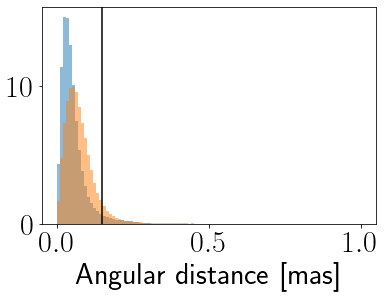

In [298]:
plt.hist(gaia_nodist.angdist*1e3, 100, range=(0, 1), density=True, alpha=.5);
plt.hist(gaia_nodist.kepler_gaia_ang_dist, 100, range=(0, 1), density=True, alpha=.5);
plt.axvline(.15, color="k")
plt.xlabel("Angular distance [mas]");

Loading (hopefully) Bailer-Jones distances. 

In [247]:
with fits.open("../data/distances-result.fits") as data:
    dist = pd.DataFrame(data[1].data, dtype="float64")

Remove stars with negative parallaxes, apply S/N cuts, and remove stars with large angular separations.

In [291]:
gaia0 = pd.merge(gaia_nodist, dist, how="left", on="source_id", suffixes=["", "_bailer-jones"])

# Remove stars with negative parallaxes and apply some S/N cuts.
m = gaia0.parallax.values > 0

sn = gaia0.parallax.values/gaia0.parallax_error.values
m = (sn > 10)

m &= (gaia0.parallax.values > 0) * np.isfinite(gaia0.parallax.values)

m &= gaia0.astrometric_excess_noise.values < 5

gaia0 = gaia0.iloc[m]
print(len(gaia0), "stars after S/N cuts")

# Remove stars with large angular separations between crossmatches.
m = gaia0.angdist.values*1e3 < .15
m &= gaia0.kepler_gaia_ang_dist.values < .15

gaia0 = gaia0.iloc[m]
print(len(gaia0), "stars after angular distance cuts")

201452 stars after S/N cuts
180083 stars after angular distance cuts


Drop targets with multiple matches.

In [292]:
def drop_multi_matches(df, ang_sep_column, duplicated_column):
    df_sorted = df.sort_values(by=ang_sep_column, ascending=True)
    df_dropped = df_sorted.drop_duplicates(subset=duplicated_column, keep="first")
    return df_dropped

In [293]:
# If a target is duplicated, keep the one with the smallest angular separation.
# Drop stars with the same Kepler ID
gaia_dropped = drop_multi_matches(gaia0, "kepler_gaia_ang_dist", "kepid")
print(len(gaia0)-len(gaia_dropped), "Stars with the same Kepler ID dropped")

# Drop stars with the same Gaia ID
gaia = drop_multi_matches(gaia_dropped, "kepler_gaia_ang_dist", "source_id")
print(len(gaia_dropped)-len(gaia), "Stars with the same Gaia ID dropped")

print("shape after cuts = ", np.shape(gaia))

13437 Stars with the same Kepler ID dropped
566 Stars with the same Gaia ID dropped
shape after cuts =  (166080, 144)


Load the LAMOST-Gaia-Kepler crossmatch perfomed in Lamost_xmatching.ipynb and remove stars with separations larger than 1.5 arcseconds.

In [300]:
lamost0 = pd.read_csv("../data/lamost_gaia_kepler_crossmatch.csv")
lam_cut = lamost0.gaia_lamost_angular_separation_arcsec.values < .15
lamost = lamost0.iloc[lam_cut]

print(len(lamost0), len(lamost))

62217 53752


In [ ]:
# np.array([k for k in lamost.keys()])

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lamost.teff.values, lamost.teff_lamost.values, ".", ms=2, alpha=.5, mec="none", rasterized=True)
plt.xlabel("Gaia Teff [K]")
plt.ylabel("LAMOST Teff [K]")

plt.subplot(1, 2, 2)
plt.hist(lamost0.gaia_lamost_angular_separation_arcsec, 100, range=(0, 1));
plt.hist(lamost.gaia_lamost_angular_separation_arcsec, 100, range=(0, 1));
plt.axvline(.15, color="k")
plt.xlabel("LAMOST-Gaia angular separation")

plt.tight_layout()

Just keep the lamost columns you need.

In [ ]:
lam = pd.DataFrame(dict({"source_id": lamost.source_id.values,
                          "LAMOST_RV": lamost.rv.values,
                          "LAMOST_RV_ERR": lamost.rv_err.values,
                          "LAMOST_DESIGNATION": lamost.designation_lamost.values,
                          "LAMOST_TEFF": lamost.teff_lamost.values,
                          "LAMOST_TEFF_ERR": lamost.teff_err.values,
                          "gaia_lamost_angular_separation_arcsec": lamost.gaia_lamost_angular_separation_arcsec.values}))

Drop sources with multiple matches.

In [ ]:
lamost_dropped = drop_multi_matches(lam, "gaia_lamost_angular_separation_arcsec", "source_id")
print(len(lam)-len(lamost_dropped), "Stars with the same Gaia source ID dropped")
lamost_dropped2 = drop_multi_matches(lamost_dropped, "gaia_lamost_angular_separation_arcsec", "LAMOST_DESIGNATION")
print(len(lamost_dropped)-len(lamost_dropped2), "Stars with the same LAMOST ID dropped")

# Load APOGEE data

In [ ]:
# Load Joel's APOGEE-Gaia EDR3 Xmatch
tbl = Table.read("../data/apogee_dr16_tmass_psc_edr3_xmatch.fits", format='fits')  # This is Joel's new version
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
_apo3 = tbl[names].to_pandas()

In [ ]:
# np.array([k for k in _apo3.keys()])

In [ ]:
apo3 = pd.DataFrame(dict({"dr2_source_id": _apo3.dr2_source_id.values,
                          "dr3_source_id": _apo3.dr3_source_id.values,
                          "tmass_edr3_angular_distance": _apo3.tmass_edr3_angular_distance.values}))

In [ ]:
# Load Adrian's APOGEE-Gaia DR2 crossmatch
tbl = Table.read("../data/apogeedr16_stars.fits", format='fits')
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
_apo2 = tbl[names].to_pandas()

In [ ]:
# np.array([k for k in _apo2.keys()]) # See https://www.sdss.org/dr12/irspec/radialvelocities/

In [219]:
apo2 = pd.DataFrame(dict({"dr2_source_id": _apo2.GAIA_SOURCE_ID.values,
                          "APOGEE_RV": _apo2.VHELIO_AVG.values,
                          "APOGEE_RV_err": _apo2.VERR.values,
                          "APOGEE_TEFF": _apo2.TEFF.values,
                          "APOGEE_TEFF_ERR": _apo2.TEFF_ERR.values,
                          "APOGEE_ID": _apo2.APOGEE_ID.values}))

In [220]:
# Merge on Gaia DR2 source ID. 
apo1 = pd.merge(apo2, apo3, how="left", on="dr2_source_id")

# Merge with the Gaia-Kepler crossmatch
apo0 = pd.merge(gaia, apo1, left_on="source_id", right_on="dr2_source_id")

In [221]:
# np.array([k for k in apo0.keys()])

Remove stars with very different effective temperatures and stars with large angular separations.

In [222]:
apo_residuals = apo0.APOGEE_TEFF.values - apo0.teff.values
median = np.median(apo_residuals)
m_apo = (apo_residuals < median + 500) & (median - 500 < apo_residuals)
apo_cut = apo0.tmass_edr3_angular_distance.values < .15
apo = apo0.iloc[apo_cut & m_apo]

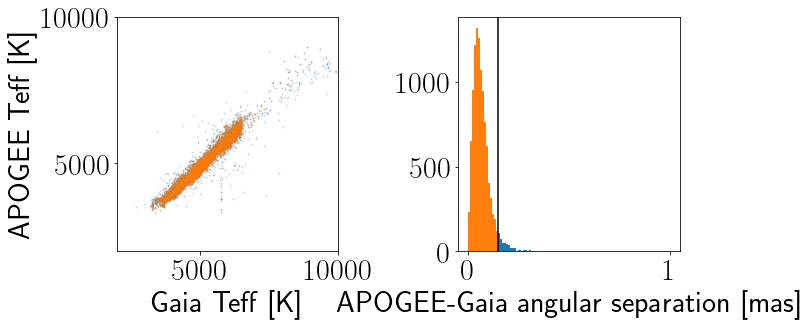

In [223]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(apo0.teff.values, apo0.APOGEE_TEFF.values, ".", ms=2, alpha=.2, rasterized=True)
plt.plot(apo.teff.values, apo.APOGEE_TEFF.values, ".", ms=2, alpha=.2, rasterized=True)
plt.xlim(2000, 10000)
plt.ylim(2000, 10000)
plt.xlabel("Gaia Teff [K]")
plt.ylabel("APOGEE Teff [K]")

plt.subplot(1, 2, 2)
plt.hist(apo0.tmass_edr3_angular_distance, 100, range=(0, 1));
plt.hist(apo0.tmass_edr3_angular_distance[apo_cut], 100, range=(0, 1));
plt.axvline(.15, color="k")
plt.xlabel("APOGEE-Gaia angular separation [mas]")

plt.tight_layout()

In [224]:
apo_dropped = drop_multi_matches(apo, "tmass_edr3_angular_distance", "source_id")
print(len(apo)-len(apo_dropped), "Stars with the same Gaia source ID dropped")
apo_dropped2 = drop_multi_matches(apo_dropped, "tmass_edr3_angular_distance", "APOGEE_ID")
print(len(apo_dropped)-len(apo_dropped2), "Stars with the same APOGEE ID dropped")

53 Stars with the same Gaia source ID dropped
0 Stars with the same APOGEE ID dropped


Just keep the parameters you're interested in.

In [225]:
apo_stripped = pd.DataFrame(dict({"dr2_source_id": apo_dropped.dr2_source_id.values,
                                  "source_id": apo_dropped.source_id.values,
                                  "APOGEE_RV": apo_dropped.APOGEE_RV.values,
                                  "APOGEE_RV_ERR": apo_dropped.APOGEE_RV_err.values,
                                  "APOGEE_TEFF": apo_dropped.APOGEE_TEFF.values,
                                  "APOGEE_TEFF_ERR": apo_dropped.APOGEE_TEFF_ERR.values,
                                  "APOGEE_ID": apo_dropped.APOGEE_ID.values}))

Crossmatch back with the Gaia-Kepler crossmatch.

In [226]:
gaia_kep_lamost = pd.merge(gaia, lamost_dropped, on="source_id", how="left")
gaia_kep_lamost_apogee = pd.merge(gaia_kep_lamost, apo_stripped, on="source_id", how="left")

In [227]:
print(np.shape(gaia), np.shape(gaia_kep_lamost), np.shape(gaia_kep_lamost_apogee))

(192910, 101) (192910, 107) (192910, 113)


In [228]:
gaia_kep_lamost_apogee.to_csv("../data/gaia_kep_lamost_apogee.csv")

In [229]:
df = gaia_kep_lamost_apogee*1

In [230]:
np.array([k for k in df.keys()])

array(['designation', 'source_id', 'gaia_ref_epoch', 'ra', 'ra_error',
       'dec', 'dec_error', 'parallax', 'parallax_error',
       'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr',
       'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr',
       'pmra_pmdec_corr', 'astrometric_chi2_al',
       'astrometric_excess_noise', 'astrometric_excess_noise_sig',
       'astrometric_primary_flag', 'duplicated_source',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'bp_rp', 'bp_g', 'g_rp', 'radial_velocity',
       'radial_velocity_error', 'phot_variable_flag', 'l', 'b', 'ecl_lon',
       'ecl_lat', 'teff_val', 'teff_percentile_lower',
       'teff_percentile_upper',

# Now correct the LAMOST and APOGEE RVs to Gaia.

In [231]:
rv, rv_err = [np.ones(len(df))*np.nan for i in range(2)]

ml = np.isfinite(df.LAMOST_RV.values)
mg = np.isfinite(df.radial_velocity.values) & (df.radial_velocity.values != 0)
ma = np.isfinite(df.APOGEE_RV.values)
mlmgma = ml & mg & ma
mlmg = ml & mg
mamg = ma & mg
maml = ma & ml

In [232]:
print(f"{len(df)} stars in total, {sum(ml)} with LAMOST RVs, {sum(ma)} with APOGEE RVs, {sum(mg)} with Gaia DR2 RVs, "\
      f"and {sum(mlmgma)} with all three")

192910 stars in total, 26860 with LAMOST RVs, 9602 with APOGEE RVs, 30171 with Gaia DR2 RVs, and 2424 with all three


Correct the LAMOST RVs to the Gaia ones:

In [233]:
def fit_line(x, y, yerr):
    AT = np.vstack((np.ones(len(x)), x))
    C = np.eye(len(x))*yerr
    CA = np.linalg.solve(C, AT.T)
    Cy = np.linalg.solve(C, y)
    ATCA = np.dot(AT, CA)
    ATCy = np.dot(AT, Cy)
    w = np.linalg.solve(ATCA, ATCy)

    cov = np.linalg.inv(ATCA)
    sig = np.sqrt(np.diag(cov))
    return w, sig

In [234]:
# Correct LAMOST RVs
x, y = df.radial_velocity.values[mlmg], df.LAMOST_RV.values[mlmg]-df.radial_velocity.values[mlmg]
yerr = df.LAMOST_RV_ERR.values[mlmg]
w, sig = fit_line(x, y, yerr)

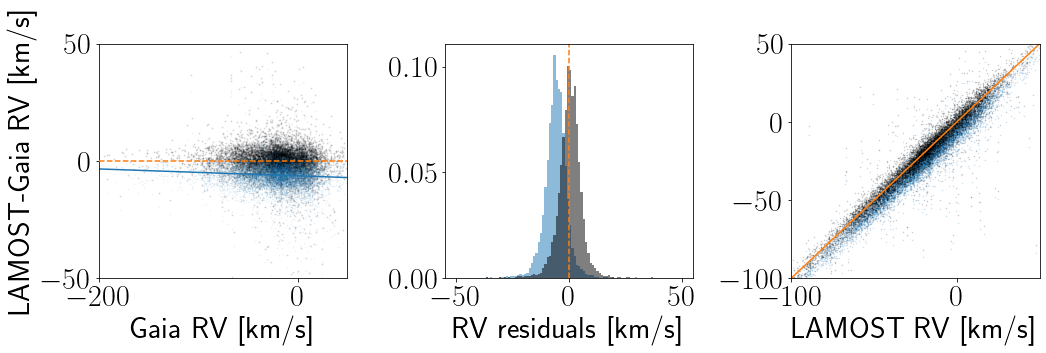

In [235]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)

plt.errorbar(x, y, fmt="C0.", ms=1, alpha=.1, rasterized=True, zorder=1)

xs = np.linspace(min(x), max(x), 100)
plt.plot(xs, w[0] + w[1]*xs, zorder=2, color="C0")
plt.axhline(0, color="C1", ls="--", zorder=3)
plt.xlim(-200, 50)
plt.ylim(-50, 50)

plt.errorbar(x, y-(w[0]+w[1]*y), fmt="k.", ms=2, alpha=.1, rasterized=True, zorder=0)

plt.xlabel("Gaia RV [km/s]")
plt.ylabel("LAMOST-Gaia RV [km/s]")

lamost_corrected = df.LAMOST_RV.values - (w[0] + w[1]*df.LAMOST_RV.values)
df["lamost_corrected_rv"] = lamost_corrected

plt.subplot(1, 3, 2)
plt.hist(y, 100, density=True, alpha=.5, range=(-50,50));
plt.hist(y-(w[0]+w[1]*y), 100, density=True, alpha=.5, range=(-50,50), color="k");
plt.axvline(0, color="C1", ls="--")
plt.xlabel("RV residuals [km/s]")

plt.subplot(1, 3, 3)
plt.plot(df.radial_velocity.values[mlmg], df.LAMOST_RV.values[mlmg], ".", ms=1, alpha=.2, rasterized=True)
plt.plot(df.radial_velocity.values[mlmg], df.lamost_corrected_rv.values[mlmg], "k.", ms=1, alpha=.2, rasterized=True)
plt.plot(xs, xs)
plt.xlim(-100, 50)
plt.ylim(-100, 50)
plt.xlabel("Gaia RV [km/s]")
plt.xlabel("LAMOST RV [km/s]")

plt.tight_layout()

In [236]:
# Correct APOGEE RVs
x, y = df.radial_velocity.values[mamg], df.APOGEE_RV.values[mamg]-df.radial_velocity.values[mamg]
yerr = df.APOGEE_RV_ERR.values[mamg]
w, sig = fit_line(x, y, yerr)

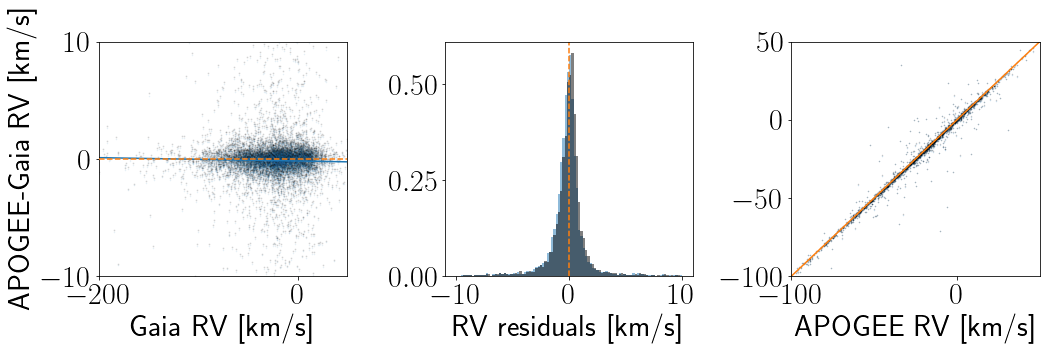

In [237]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)

plt.errorbar(x, y, fmt="C0.", ms=1, alpha=.1, rasterized=True, zorder=1)

xs = np.linspace(min(x), max(x), 100)
plt.plot(xs, w[0] + w[1]*xs, zorder=2, color="C0")
plt.axhline(0, color="C1", ls="--", zorder=3)
plt.xlim(-200, 50)
plt.ylim(-10, 10)

plt.errorbar(x, y-(w[0]+w[1]*y), fmt="k.", ms=2, alpha=.1, rasterized=True, zorder=0)

plt.xlabel("Gaia RV [km/s]")
plt.ylabel("APOGEE-Gaia RV [km/s]")

apogee_corrected = df.APOGEE_RV.values - (w[0] + w[1]*df.APOGEE_RV.values)
df["apogee_corrected_rv"] = apogee_corrected

plt.subplot(1, 3, 2)
plt.hist(y, 100, density=True, alpha=.5, range=(-10,10));
plt.hist(y-(w[0]+w[1]*y), 100, density=True, alpha=.5, range=(-10,10), color="k");
plt.axvline(0, color="C1", ls="--")
plt.xlabel("RV residuals [km/s]")

plt.subplot(1, 3, 3)
plt.plot(df.radial_velocity.values[mlmg], df.APOGEE_RV.values[mlmg], ".", ms=1, alpha=.2, rasterized=True)
plt.plot(df.radial_velocity.values[mlmg], df.apogee_corrected_rv.values[mlmg], "k.", ms=1, alpha=.2, rasterized=True)
plt.plot(xs, xs)
plt.xlim(-100, 50)
plt.ylim(-100, 50)
plt.xlabel("Gaia RV [km/s]")
plt.xlabel("APOGEE RV [km/s]")

plt.tight_layout()

# Now combine the RVs into a single column.

In [238]:
rv[ml] = lamost_corrected[ml]
rv_err[ml] = df.LAMOST_RV_ERR.values[ml]
print(sum(ml), "stars with LAMOST RVs")

# Overwrite LAMOST RVs with Gaia RVs
rv[mg] = df.radial_velocity.values[mg]
rv_err[mg] = df.radial_velocity_error.values[mg]
print(sum(mg), "stars with Gaia RVs")

# Overwrite Gaia RVs with APOGEE RVs
rv[ma] = apogee_corrected[ma]
rv_err[ma] = df.APOGEE_RV.values[ma]
print(sum(ma), "stars with APOGEE RVs")

26860 stars with LAMOST RVs
30171 stars with Gaia RVs
9602 stars with APOGEE RVs


In [239]:
df["rv"] = rv
df["rv_err"] = rv_err

In [241]:
df.to_csv("../data/rv_data.csv")